In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in greater


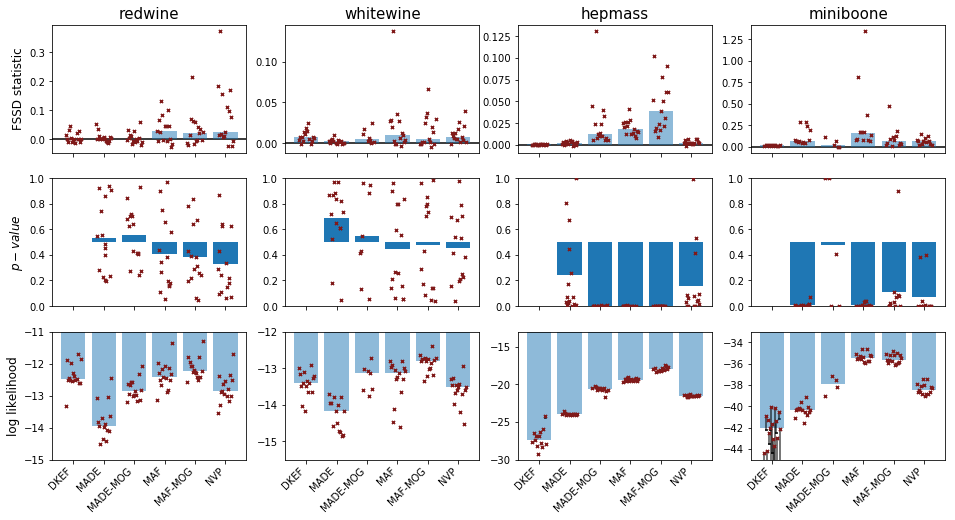

In [27]:
dnames = ["redwine", "whitewine", "hepmass", "miniboone"]
fig, axes = plt.subplots(3, len(dnames), figsize=(4 * len(dnames), 8),  squeeze=False, sharex=True)


loglik_limits = dict(redwine=-np.inf, whitewine=-50, parkinsons=-20, hepmass=-30, miniboone=-45)
ylims = dict(redwine=(-15,-11), whitewine=(-15.5,-12), parkinsons=(-16,-11), hepmass=(-30,-13), miniboone=(-45,-33))


display_names = dict(dkef="DKEF", made="MADE", maf="MAF", made_mog = "MADE-MOG", maf_mog="MAF-MOG", nvp="NVP")

pth = os.path.expanduser('')

bias_fn= "/nfs/nhome/live/dougals/deep-kexpfam/bias-ests.csv"

for di, dname in enumerate(dnames):
    
    
    ############ log likelihoods ############
    ax = axes[2,di]
    with np.load("logliks_%s.npz"%dname) as f:
        lls = f["lls"].T
        
    jitter = 0.25
        
    n_in_est=10 if dname == "miniboone" else 9
    bias_df = pd.read_csv(bias_fn)
    bias = bias_df.query("dset=='%s' and n_in_est==%d"%(dname, n_in_est))["bias_est"].values
    
    lls_dkef = lls[0,:]
    #lls_dkef = lls_dkef[lls_dkef>loglik_limits[dname]]
    
    # exclude out liers
    lls = np.where(lls>loglik_limits[dname], lls, np.full_like(lls, np.nan))
    pos = np.arange(lls.shape[0]) - 1
    
    ax.bar(pos, np.nanmedian(lls, axis=1), alpha=.5, )# yerr=np.nanstd(fssd2s, axis=1)
    
    
    x = np.repeat(pos[None,:], [lls.shape[1]], axis=0)#.flatten()
    x = x + np.linspace(-jitter, jitter, num=lls.shape[1])[:, np.newaxis]
    
    # bias lines before flattening x
    ax.plot(np.tile(x[:,0], [2,1]), np.c_[lls_dkef, lls_dkef-bias].T, "k", alpha=0.7)
    ax.scatter(x[:,0], lls_dkef-bias.T, 9, "k", marker = "_", alpha=1, )


    x = x.flatten()
    #x = x + np.random.uniform(-0.15, 0.15, *x.shape)
    ax.scatter(x, lls.T.flatten(), 10, color=(.5,.1,.1), marker="x", zorder=3)
    
    
    ax.set_ylim(ylims[dname])
    
    ########## p-value
    ax = axes[1, di]
    
    test_res = np.load(os.path.join(pth, "stein_gauss_%s.npz" % dname.lower()))
    
    ps = test_res["ps"]
    stats = test_res["stats"]
    model_names = test_res["model_names"]

    pvalues = ps[:, 1:, 0]

    ax.bar(np.arange(5), np.nanmean(pvalues,0) - 0.5, bottom=0.5)
    
    x = np.repeat(np.arange(5)[None,:],[ps.shape[0]], axis=0).flatten()
    x = x + np.random.uniform(-jitter, jitter, *x.shape)
    ax.scatter(x, pvalues.flatten(), 10, color=(.5,.1,.1), marker="x", zorder=3)
       
    ax.set_xticks(range(5))
    ax.set_xticklabels([display_names[k] for k in model_names[1:]], rotation=45, ha="right", position=(0.0,0.01))
    ax.set_ylim([0,1])

    
    fssd2s = np.full((len(model_names), stats.shape[0]), np.nan)
    fssd2s[0, :] = test_res['dkef_vals'] / test_res['ntest']
    fssd2s[1:, :] = fssd2s[0, :] - test_res['stats'][:, 0, 1:].T / np.sqrt(test_res['ntest'])
    
    ######### FSSD ##########
    ax = axes[0, di]
    
    pos = np.arange(fssd2s.shape[0]) - 1
    
    ax.bar(pos, np.nanmedian(fssd2s, axis=1), alpha=.5, )# yerr=np.nanstd(fssd2s, axis=1)
    
    x = np.repeat(pos[None,:], [fssd2s.shape[1]], axis=0)#.flatten()
    x = x + np.linspace(-jitter, jitter, num=fssd2s.shape[1])[:, np.newaxis]
    x = x.flatten()
    #x = x + np.random.uniform(-0.15, 0.15, *x.shape)
    ax.scatter(x, fssd2s.T.flatten(), 10, color=(.5,.1,.1), marker="x", zorder=3)
    
    #ax.set_yscale('symlog')
    ax.axhline(0, color='k', zorder=-1)

    

for i in range(len(dnames)):
    ax = axes[0, i]
    ax.set_title(dnames[i], fontsize=15)
    
    ax = axes[2,i]   
    ax.set_xticks(np.arange(len(model_names)) - 1)
    ax.set_xticklabels([display_names[k] for k in model_names], rotation=45, ha="right", position=(0.0,0.01))
    
axes[0,0].set_ylabel("FSSD statistic", fontsize=12)
axes[1,0].set_ylabel(r"$p-value$", fontsize=12)
axes[2,0].set_ylabel("log likelihood", fontsize=12)